In [1]:
!pip install wget
!pip install transformers

  Created wheel for wget: filename=wget-3.2-cp37-none-any.whl size=9681 sha256=85831746c0fd974f767f5389edcd7df66fc27a760dcbcbf6e37a36329dd41527
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget
     |████████████████████████████████| 1.9MB 17.3MB/s 
     |████████████████████████████████| 3.2MB 46.9MB/s 
     |████████████████████████████████| 890kB 46.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=3e3a07d1d1071b19c51f050b0f522bbb0d7687794ba6cdca90e2de06da427e6f
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from transformers import BertTokenizer
import seaborn as sns


import torch

In [3]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print( torch.cuda.device_count())
    print('Available:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

1
Available: Tesla T4


**Download datasets**

In [4]:
url_train='https://groups.csail.mit.edu/sls/downloads/movie/engtrain.bio'
url_test='https://groups.csail.mit.edu/sls/downloads/movie/engtest.bio'

In [5]:
import wget
import os

In [6]:
print(wget.download(url_train))
print(wget.download(url_test))

engtrain.bio
engtest.bio


**Extracting data from BIO format**

In [7]:
import csv

def read_data(location):
  statement = []
  labels = []

  tokens = []
  token_labels = []
  unique_labels = set()

  with open(location, newline = '') as lines:                                                                                          
      line_reader = csv.reader(lines, delimiter='\t')
      for line in line_reader:
          if line == []:
              statement.append(tokens)
              labels.append(token_labels)           
      
              tokens = []
              token_labels = []        
          else: 
              tokens.append(line[1])
              token_labels.append(line[0])
              unique_labels.add(line[0])
  return(statement,labels,unique_labels)

In [11]:
statement,labels,unique_labels = read_data("./engtrain.bio")

In [12]:
' '.join(statement[1])

'show me films with drew barrymore from the 1980s'

In [13]:
print("Total number of statement: {}".format(len(statement)))

Total number of statement: 9775


**Target Entity Labels**

In [14]:
Labels = {}
for (i, label) in enumerate(unique_labels):  
    # Map it to its integer
    Labels[label] = i

In [15]:
Labels

{'B-ACTOR': 5,
 'B-CHARACTER': 11,
 'B-DIRECTOR': 17,
 'B-GENRE': 6,
 'B-PLOT': 1,
 'B-RATING': 13,
 'B-RATINGS_AVERAGE': 3,
 'B-REVIEW': 15,
 'B-SONG': 14,
 'B-TITLE': 19,
 'B-TRAILER': 24,
 'B-YEAR': 0,
 'I-ACTOR': 12,
 'I-CHARACTER': 7,
 'I-DIRECTOR': 18,
 'I-GENRE': 20,
 'I-PLOT': 8,
 'I-RATING': 16,
 'I-RATINGS_AVERAGE': 9,
 'I-REVIEW': 10,
 'I-SONG': 21,
 'I-TITLE': 22,
 'I-TRAILER': 4,
 'I-YEAR': 2,
 'O': 23}

In [16]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

MAximum length of sentence present in data

In [17]:
TokenLength=[len(tokenizer.encode(' '.join(i),add_special_tokens=True)) for i in statement]
print('Min/Max/Median sentence length: {}, {}, {}'.format(min(TokenLength),max(TokenLength),int(np.median(TokenLength))))

Min/Max/Median sentence length: 3, 51, 12


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


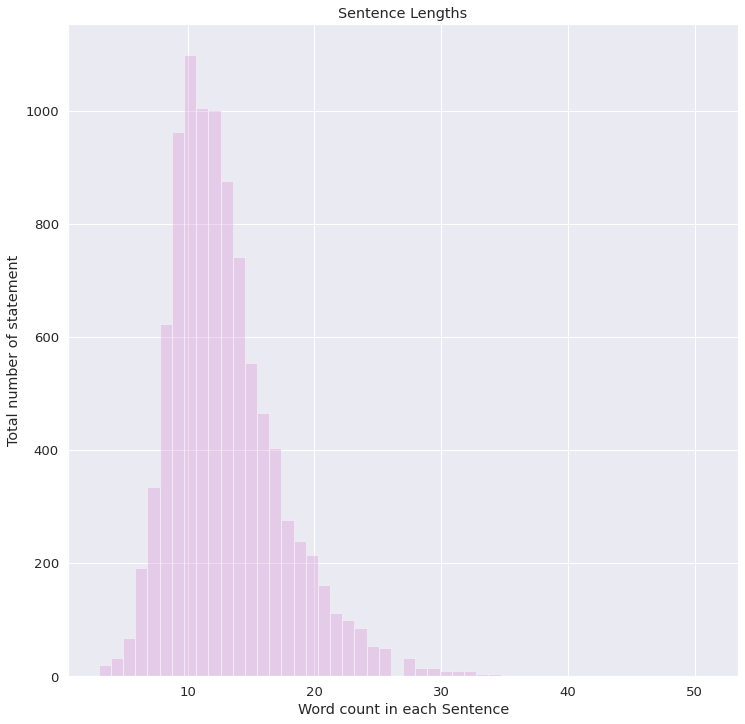

In [18]:
sns.set(style='darkgrid')
# Increase the plot size and font size.
sns.set(font_scale=1.2)
plt.figure(figsize=(12,12))
plt.rcParams["figure.figsize"] = (10,5)

# Plot the distribution of comment lengths.
sns.distplot(TokenLength, kde=False, rug=False,color='plum')
plt.title('Sentence Lengths')
plt.xlabel('Word count in each Sentence')
plt.ylabel('Total number of statement');

**Adding Attention Mask**

In [19]:
def token(statement):
  input_ids = []
  attention_masks = []
  for sent in statement:
      sent_str = ' '.join(sent)
      encoded_dict = tokenizer.encode_plus(
                          sent_str,                 
                          add_special_tokens = True,
                          truncation = True,
                          max_length = 55,           
                          pad_to_max_length = True,
                          return_attention_mask = True,   
                          return_tensors = 'pt',     
                    )
      input_ids.append(encoded_dict['input_ids'][0])
      attention_masks.append(encoded_dict['attention_mask'][0])
  return(input_ids,attention_masks)

In [20]:
input_ids, attention_masks = token(statement)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


**Encoded Entity Labels**

In [21]:
#Encoded Labels
#For "extra" tokens. 
null_label_id = -100 

def encode_label(input_ids, labels):
  new_labels = []
  for (sen, orig_labels) in zip(input_ids, labels):
      padded_labels = []
      orig_labels_i = 0 
      for token_id in sen:
          token_id = token_id.numpy().item()
          if (token_id == tokenizer.pad_token_id) or (token_id == tokenizer.cls_token_id) or (token_id == tokenizer.sep_token_id):
              padded_labels.append(null_label_id)
          elif tokenizer.ids_to_tokens[token_id][0:2] == '##':
              padded_labels.append(null_label_id)
          else:
              label_str = orig_labels[orig_labels_i]
              padded_labels.append(Labels[label_str])
              orig_labels_i += 1
      assert(len(sen) == len(padded_labels))    
      new_labels.append(padded_labels)
  return(new_labels)


In [22]:
  new_labels=encode_label(input_ids, labels)

In [23]:
print('\nSentence:    ', statement[5])
print('\nLabels:      ', labels[5])
print('\nBERT Tokens: ', tokenizer.tokenize(' '.join(statement[5])))
print('\nToken IDs:   ', input_ids[5])
print('\nNew Labels:  ', new_labels[5])
print('\nMask:        ', attention_masks[5])


Sentence:     ['what', 'movies', 'have', 'mississippi', 'in', 'the', 'title']

Labels:       ['O', 'O', 'O', 'B-TITLE', 'O', 'O', 'O']

BERT Tokens:  ['what', 'movies', 'have', 'mississippi', 'in', 'the', 'title']

Token IDs:    tensor([ 101, 2054, 5691, 2031, 5900, 1999, 1996, 2516,  102,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0])

New Labels:   [-100, 23, 23, 23, 19, 23, 23, 23, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100]

Mask:         tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,

**Conversion of list into PyTorch tensors**

In [24]:
pt_input_ids = torch.stack(input_ids, dim=0)
pt_attention_masks = torch.stack(attention_masks, dim=0)
pt_labels = torch.tensor(new_labels, dtype=torch.long)

In [25]:
pt_input_ids

tensor([[ 101, 2054, 5691,  ...,    0,    0,    0],
        [ 101, 2265, 2033,  ...,    0,    0,    0],
        [ 101, 2054, 5691,  ...,    0,    0,    0],
        ...,
        [ 101, 2054, 2079,  ...,    0,    0,    0],
        [ 101, 2265, 2033,  ...,    0,    0,    0],
        [ 101, 1045, 2215,  ...,    0,    0,    0]])

In [26]:
from torch.utils.data import TensorDataset, random_split

dataset = TensorDataset(pt_input_ids, pt_attention_masks, pt_labels)

# Create a 90-10 train-validation split.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{} training samples'.format(train_size))
print('{} validation samples'.format(val_size))

8797 training samples
978 validation samples


In [27]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32
train_data = DataLoader(train_dataset, sampler = RandomSampler(train_dataset), batch_size = batch_size )
validation_data = DataLoader(val_dataset, sampler = SequentialSampler(val_dataset), batch_size = batch_size)

**BASEBERT model**

In [28]:
from transformers import BertForTokenClassification, AdamW, BertConfig
model = BertForTokenClassification.from_pretrained("bert-base-uncased", num_labels = len(Labels) + 1, output_attentions = False, output_hidden_states = False)
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

ADAM Optimization

In [29]:
# Load the AdamW optimizer
ADAMoptimizer = AdamW(model.parameters(),
                  lr = 5e-5, # learning_rate 
                  eps = 1e-8 # adam_epsilon 
                )

In [30]:
from transformers import get_linear_schedule_with_warmup
epochs = 5

totalstp = len(train_data) * epochs
Hyperparameter = get_linear_schedule_with_warmup(ADAMoptimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = totalstp)

**Model Traing and validation**

In [31]:
import random
loss_values = []
Valid_loss_values = []
for epoch_i in range(0, epochs):
    print('Training & validating for Epoch {} / {} ========'.format(epoch_i + 1, epochs))
    Tot_loss = 0
    model.train()
    for step, batch in enumerate(train_data):  # add batch to gpu
        if step % 50 == 0 and not step == 0:
            # Report progress.
            print('  Batch {}  of  {}.'.format(step, len(train_data)))
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        model.zero_grad()     # clear any previously calculated gradients before performing a backward pass.   
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)        # forward pass
        loss = outputs[0]      # This will return the loss
        Tot_loss += loss.item()     # track train loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # prevent the "exploding gradients" problem.
        ADAMoptimizer.step() # update parameters
        Hyperparameter.step() # Update the learning rate.
    avg_train_loss = Tot_loss / len(train_data)            
    loss_values.append(avg_train_loss)
    print("  Average training loss: {}".format(avg_train_loss))

    model.eval()
    # The validation loss
    eval_loss=0
    nb_eval_steps=0
    for  batch in validation_data:  
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        with torch.no_grad():
          outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)    
        loss1 = outputs[0]    
        loss1 = loss1.detach().cpu().numpy()
        eval_loss += loss1.item()   
        nb_eval_steps += 1  
    eval_loss = eval_loss / nb_eval_steps          
    Valid_loss_values.append(eval_loss)
    print("  Average Validation loss: {}".format(eval_loss))


Training & validating for Epoch 1 / 5 ========
  Batch 50  of  275.
  Batch 100  of  275.
  Batch 150  of  275.
  Batch 200  of  275.
  Batch 250  of  275.
  Average training loss: 0.42431129840287296
  Average Validation loss: 0.23593159644834458
Training & validating for Epoch 2 / 5 ========
  Batch 50  of  275.
  Batch 100  of  275.
  Batch 150  of  275.
  Batch 200  of  275.
  Batch 250  of  275.
  Average training loss: 0.17899762317538262
  Average Validation loss: 0.20695558719096646
Training & validating for Epoch 3 / 5 ========
  Batch 50  of  275.
  Batch 100  of  275.
  Batch 150  of  275.
  Batch 200  of  275.
  Batch 250  of  275.
  Average training loss: 0.1279580890184099
  Average Validation loss: 0.21413436483952306
Training & validating for Epoch 4 / 5 ========
  Batch 50  of  275.
  Batch 100  of  275.
  Batch 150  of  275.
  Batch 200  of  275.
  Batch 250  of  275.
  Average training loss: 0.09504588915543123
  Average Validation loss: 0.21953660417949
Training & v

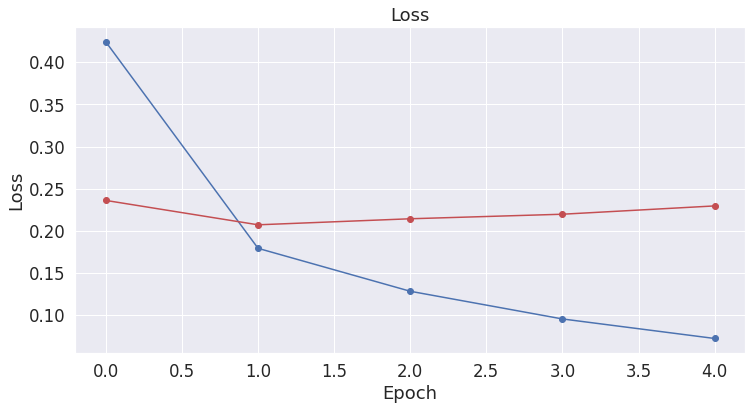

In [32]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o',label="Training loss")
plt.plot(Valid_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

**Test Data**

In [33]:
#test data
statement,labels,unique_labels = read_data("./engtest.bio")

In [34]:
input_ids = []
attention_masks = []
#Tokenization
input_ids, attention_masks = token(statement)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [35]:
new_labels=encode_label(input_ids, labels)

In [36]:
pt_input_ids = torch.stack(input_ids, dim=0)
pt_attention_masks = torch.stack(attention_masks, dim=0)
pt_labels = torch.tensor(new_labels, dtype=torch.long)

In [37]:
batch_size = 32  
prediction_data = TensorDataset(pt_input_ids, pt_attention_masks, pt_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [38]:
#prediction
model.eval()
predictions , true_labels = [], []

for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None,attention_mask=b_input_mask)
  logits = outputs[0]
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  predictions.append(logits)
  true_labels.append(label_ids)


In [39]:
# First, combine the results across the batches.
all_predictions = np.concatenate(predictions, axis=0)
all_true_labels = np.concatenate(true_labels, axis=0) 
predicted_label_ids = np.argmax(all_predictions, axis=2)

# Merge all to 1 value
predicted_label_ids = np.concatenate(predicted_label_ids, axis=0)
all_true_labels = np.concatenate(all_true_labels, axis=0)

print("  we have predictions:  ", predicted_label_ids.shape)

  we have predictions:   (134365,)


In [40]:
# Construct new lists of predictions which don't include any null tokens.
real_token_predictions = []
real_token_labels = []

for i in range(len(all_true_labels)):
    if not all_true_labels[i] == -100:
        real_token_predictions.append(predicted_label_ids[i])
        real_token_labels.append(all_true_labels[i])

print("Before filtering null tokens, length = {}".format(len(all_true_labels)))
print(" After filtering null tokens, length = {}".format(len(real_token_labels)))

Before filtering null tokens, length = 134365
 After filtering null tokens, length = 24686


**Performance Matrix**

In [41]:
from sklearn.metrics import f1_score
f1 = f1_score(real_token_labels, real_token_predictions, average='micro') 
print ("F1 score: {:.2%}".format(f1))

F1 score: 94.30%


In [42]:
from sklearn import metrics
# Print the precision and recall, among other metrics
print(metrics.classification_report(real_token_labels, real_token_predictions, digits=2))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95       720
           1       0.77      0.77      0.77       491
           2       0.97      0.97      0.97       610
           3       0.93      0.92      0.93       451
           4       0.00      0.00      0.00         8
           5       0.92      0.96      0.94       812
           6       0.94      0.97      0.95      1117
           7       0.53      0.53      0.53        75
           8       0.75      0.69      0.72       496
           9       0.88      0.92      0.90       403
          10       0.54      0.16      0.24        45
          11       0.64      0.67      0.65        90
          12       0.92      0.95      0.94       862
          13       0.96      0.97      0.97       500
          14       0.72      0.70      0.71        54
          15       0.42      0.27      0.33        56
          16       0.93      0.92      0.93       226
          17       0.95    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
